In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from scipy import stats

from preprocessing.getdata import *

In [2]:
import logging
from logging import getLogger
import mlflow
from modelling.config import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/55', experiment_id='55', lifecycle_stage='active', name='alzbusters_2D_CNN_MRI', tags={}>

In [3]:
logger = logging.getLogger()
logging.basicConfig(format="%(asctime)s: %(message)s")
logging.getLogger("pyhive").setLevel(logging.CRITICAL)  # avoid excessive logs
logger.setLevel(logging.INFO)

In [20]:
mlflow.start_run()

data = "OASIS"

# load csv_file
if data == "OASIS":
    logger.info(f"Loading OASIS-csv, drop_young=True, drop_contradictions=True")
    df = get_csvdata(drop_young=True, drop_contradictions=True)
elif data == "ADNI":
    logger.info(f"Loading ADNI-csv, drop_MCI= True")
    df = get_csvdata_ADNI(drop_MCI = True)

#split dataframe into train and test
logger.info("Train test split on dataframe")
dfTrain, dfTest, y_train, y_test = train_test_split(df, df['label'], stratify = df['label'], random_state=42)

mlflow.set_tag("Dataset", data)

2022-08-24 14:32:28,143: Loading OASIS-csv, drop_young=True, drop_contradictions=True
2022-08-24 14:32:28,153: Train test split on dataframe


In [21]:
logger.info("empty training_history instantiated")
training_history= {}

2022-08-24 14:32:28,211: empty training_history instantiated


In [22]:
# load image data (N slices above and below the plane (m), suggested by the datasource)
# standard values for m are 95 for dim=0, 110 for dim=1, 90 for dim=2

N, d, m, dim, norm, file = 0, 1, 90, 2, True, "masked"
Ntest=0

if data == "OASIS":
    logger.info(f"Loading 2D-OASIS train data: N,d,m,dim,norm,file={N},{d},{m},{dim},{norm},{file}")
    X_train = get_slices(dfTrain['ID'], N=N, d=d, m=m, dim=dim, normalize=norm, file=file)
    
    logger.info(f"Loading 2D-OASIS test data: Ntest,d,m,dim,norm,file={Ntest},{d},{m},{dim},{norm},{file}")
    X_test = get_slices(dfTest['ID'], m=m, d=d, dim=dim, N=Ntest, normalize=norm, file=file)

elif data == "ADNI":
    logger.info(f"Loading 2D-OASIS train data: N,d,m,dim,norm,file={N},{d},{m},{dim},{norm},{file}")
    X_train = get_slices_ADNI(dfTrain['ID'], N=N, d=d, m=m, dim=dim, normalize=norm)
    
    logger.info(f"Loading 2D-OASIS test data: Ntest,d,m,dim,norm,file={Ntest},{d},{m},{dim},{norm},{file}")
    X_test = get_slices_ADNI(dfTest['ID'], m=m, d=d, dim=dim, N=Ntest, normalize=norm)

else:
    logger.error("no dataset speficied")

#expand y_train to the same length as X_train
y_train = y_train.repeat(1+2*N) 

data_params = f"N,d,m,dim,Ntest,norm,file={N},{d},{m},{dim},{Ntest},{norm},{file}"
mlflow.log_params({"loading-params": data_params})

2022-08-24 14:32:28,239: Loading 2D-OASIS train data: N,d,m,dim,norm,file=0,1,90,2,True,masked
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 14:32:28,242: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 14:32:28,243: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 14:32:28,427: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 14:32:28,429: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 14:32:28,567: very large origin values relative to dims; leaving as set, ignoring f

In [23]:
HEIGHT = X_train.shape[1]
WIDTH = X_train.shape[2]
mlflow.tensorflow.autolog()

In [24]:
'''model = Sequential()
model_name = "CNN_8-16"
logger.info(f"CNN model instantiated: {model_name}")
mlflow.set_tag(model_name)
# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Dropout(0.2))
model.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())'''
;

''

In [25]:
model = Sequential()
model_name = "CNN_8-16_lessReg"
logger.info(f"CNN model instantiated: {model_name}")
mlflow.set_tag("Model Name",model_name)
# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(8, 3, activation="relu", padding="same"))
model.add(Conv2D(8, 3, activation="relu", padding="same"))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(Conv2D(16, 3, activation="relu", padding="same"))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Conv2D(32, 3, activation="relu", padding="same"))
#model.add(Conv2D(32, 3, activation="relu", padding="same"))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
model.add(Flatten())
model.add(Dense(units=64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())


2022-08-24 14:32:55,261: CNN model instantiated: CNN_8-16_lessReg


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 176, 208, 8)       80        
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 208, 8)       584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 88, 104, 8)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 88, 104, 16)       1168      
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 104, 16)       2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 44, 52, 16)       0         
 2D)                                                  

In [26]:
'''model = Sequential()
model_name = "VGG16"
logger.info(f"CNN model instantiated: {model_name}")
mlflow.set_tag(model_name)
# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())''';

In [27]:
BATCH_SIZE= 32
VAL_SPLIT= 0.2
EPOCHS=25
logger.info(f"Fitting model and storing history: batch_size={BATCH_SIZE},validation_split={VAL_SPLIT},epochs={EPOCHS}")
training_history[model_name+data_params] = model.fit(X_train, y_train, batch_size = BATCH_SIZE, validation_split=VAL_SPLIT, epochs = EPOCHS)

2022-08-24 14:32:55,476: Fitting model and storing history: batch_size=32,validation_split=0.2,epochs=25
2022/08/24 14:32:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: No module named 'boto3'


Epoch 1/25


2022-08-24 14:32:56.815686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.6667 - accuracy: 0.4722

2022-08-24 14:32:57.754676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 218ms/step - loss: 1.6667 - accuracy: 0.4722 - val_loss: 1.1324 - val_accuracy: 0.3929
Epoch 2/25
4/4 [==============================] - 0s 92ms/step - loss: 0.9963 - accuracy: 0.5278 - val_loss: 0.8113 - val_accuracy: 0.3929
Epoch 3/25
4/4 [==============================] - 0s 71ms/step - loss: 0.7670 - accuracy: 0.5278 - val_loss: 0.7642 - val_accuracy: 0.3929
Epoch 4/25
4/4 [==============================] - 0s 137ms/step - loss: 0.7399 - accuracy: 0.5278 - val_loss: 0.7631 - val_accuracy: 0.3929
Epoch 5/25
4/4 [==============================] - 0s 77ms/step - loss: 0.7554 - accuracy: 0.5278 - val_loss: 0.7653 - val_accuracy: 0.3929
Epoch 6/25
4/4 [==============================] - 0s 71ms/step - loss: 0.7528 - accuracy: 0.5278 - val_loss: 0.7466 - val_accuracy: 0.3929
Epoch 7/25
4/4 [==============================] - 0s 77ms/step - loss: 0.7312 - accuracy: 0.5278 - val_loss: 0.7263 - val_accuracy: 0.3929
Epoch 8/25
4/4 [====================

2022-08-24 14:33:07,131: Assets written to: /var/folders/hs/zvkng9r54wg2zhd69f8h_f280000gn/T/tmp1uez6uyi/model/data/model/assets
2022/08/24 14:33:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: No module named 'boto3'


In [28]:
# prediction of outcomes and conversion to binary
logger.info("Predicting on Xtest")
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs>0.5).astype(int)

2022-08-24 14:33:12,010: Predicting on Xtest
2022-08-24 14:33:12.085252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [29]:
# reshape is necessary if X_test also consists of multiple slices per sample

if Ntest != 0:
    test_length, slices_per_test_sample = dfTest.shape[0], int(y_pred.shape[0]/dfTest.shape[0])

    l = []
    for i in range(test_length):
        for j in np.where(y_pred.reshape((test_length,slices_per_test_sample))[i]==y_test.values[i])[0]:
            l.append(j)

    for i in range(12):
        print(i, l.count(i))

    y_pred = np.array(stats.mode(y_pred.reshape((test_length,slices_per_test_sample)), axis=1, keepdims=False))[0]

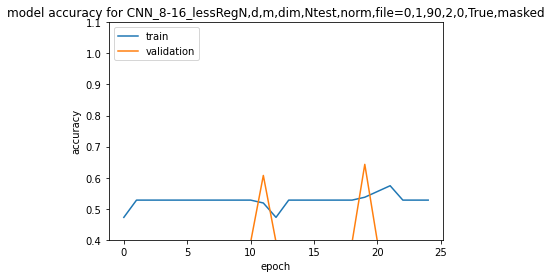

In [30]:
# summarize history for accuracy
plt.plot(training_history[model_name+data_params].history['accuracy'])
plt.plot(training_history[model_name+data_params].history['val_accuracy'])
plt.title(f"model accuracy for "+model_name+data_params)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.4,1.1])
plt.show()

In [31]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

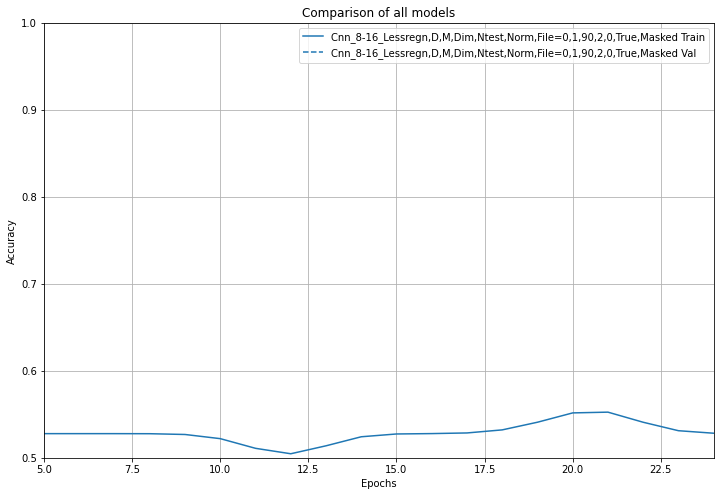

In [32]:
# Instantiate HistoryPlotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

# Plot results of all models

plt.figure(figsize=(12,8)) 
plotter.plot(training_history)
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 1])
plt.xlabel('Epochs')
plt.title('Comparison of all models')
plt.legend(loc='upper right')
plt.savefig("../models/Valle_CNN1_comparison_2.png");

accuracy:  0.5
recall:  0.0
precision:  0.0


/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


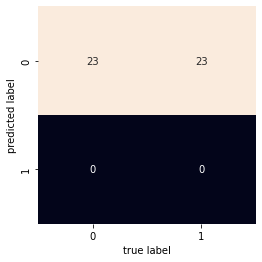

In [33]:
accuracy_score(y_test, y_pred)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

In [34]:
logger.info("Measuring prediction performance and storing on ML-Flow")

#mlflow.log_metric("train" + "-" + "acc", training_history[model_name+data_params].history['accuracy'][-1])
#mlflow.log_metric("validation" + "-" + "acc", training_history[model_name+data_params].history['val_accuracy'][-1])
mlflow.log_metric("test" + "-" + "acc", accuracy_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "recall", recall_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "precision", precision_score(y_test, y_pred.round()).round(2))


2022-08-24 14:33:12,740: Measuring prediction performance and storing on ML-Flow
/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
mlflow.end_run()